In [92]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:
$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\pi^a_i} & - \delta \phi(y) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_i \hat 
\pi^a_i \theta_i \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& + \xi_a \sum_i \hat \pi^a_i (\log \hat \pi^a_i - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [113]:
# parameters
δ = 0.01
η = 0.032
ξa = 1/100
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
λ = np.log(2)/6
numy_bar = 25
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y1_grid = np.arange(y_min, y_max+hy, hy)

# y1_grid = np.linspace(0, 4, 50)
y2_grid = np.linspace(0, 1, 50)
# mesh grid and construct state space
(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [115]:
tol = 1e-7
ϵ = 5
max_iter = 5_000
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]

solu=dict()
for i in range(3):
    π_p = np.zeros(3)
    π_p[i] = 1
    dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol:
        if episode ==0:
            v0 =  - η*(y1_mat+y2_mat)**2
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
        # updating controls


        weight = np.array([-1/ξa*v0_dy2*λ*ems_old*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
        πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = - λ*y2_mat
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat - η + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    result = dict(v0=v0, ems=ems, πa=πa)
    solu[π_p@γ3_list] = result

232.93791189324443
Episode 0: PDE Error: 1.850912292693; False Transient Error: 1.676275634234; Iterations: 1933; CG Error: 0.000000000092
End of PDE solver, takes time: 0.053649187088012695
120.45940072871521
Episode 1: PDE Error: 1.655901384264; False Transient Error: 1.241640515705; Iterations: 1855; CG Error: 0.000000000096
End of PDE solver, takes time: 0.051474809646606445
62.43142559563567
Episode 2: PDE Error: 1.263069867464; False Transient Error: 0.867426140824; Iterations: 1852; CG Error: 0.000000000095
End of PDE solver, takes time: 0.05114936828613281
32.87675487835501
Episode 3: PDE Error: 0.891150116014; False Transient Error: 0.584520434984; Iterations: 1843; CG Error: 0.000000000098
End of PDE solver, takes time: 0.05063915252685547
17.8741922606988
Episode 4: PDE Error: 0.610592443316; False Transient Error: 0.391746389611; Iterations: 1783; CG Error: 0.000000000096
End of PDE solver, takes time: 0.049303293228149414
10.284542755775307
Episode 5: PDE Error: 0.41818202

Episode 43: PDE Error: 0.003099201038; False Transient Error: 0.001704978660; Iterations: 1603; CG Error: 0.000000000091
End of PDE solver, takes time: 0.04561662673950195
2.826671693667186
Episode 44: PDE Error: 0.001914593745; False Transient Error: 0.001622096052; Iterations: 1587; CG Error: 0.000000000092
End of PDE solver, takes time: 0.04370880126953125
2.8261302452368406
Episode 45: PDE Error: 0.001717656610; False Transient Error: 0.001635863619; Iterations: 1592; CG Error: 0.000000000096
End of PDE solver, takes time: 0.043611764907836914
2.825622515678391
Episode 46: PDE Error: 0.001533216654; False Transient Error: 0.001445755949; Iterations: 1572; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0431513786315918
2.8251464240834236
Episode 47: PDE Error: 0.001575490730; False Transient Error: 0.001368598227; Iterations: 1571; CG Error: 0.000000000098
End of PDE solver, takes time: 0.04329419136047363
2.824699965934638
Episode 48: PDE Error: 0.001622054783; False Tra

Episode 87: PDE Error: 0.001598038960; False Transient Error: 0.000160336441; Iterations: 1549; CG Error: 0.000000000082
End of PDE solver, takes time: 0.042682647705078125
2.818465928299266
Episode 88: PDE Error: 0.001597230934; False Transient Error: 0.000152166310; Iterations: 1549; CG Error: 0.000000000092
End of PDE solver, takes time: 0.04252195358276367
2.818433345380744
Episode 89: PDE Error: 0.001596400642; False Transient Error: 0.000144424445; Iterations: 1531; CG Error: 0.000000000097
End of PDE solver, takes time: 0.042208194732666016
2.8184027665209808
Episode 90: PDE Error: 0.001595554377; False Transient Error: 0.000137105692; Iterations: 1531; CG Error: 0.000000000096
End of PDE solver, takes time: 0.04213142395019531
2.818374068339787
Episode 91: PDE Error: 0.001594695655; False Transient Error: 0.000130188568; Iterations: 1548; CG Error: 0.000000000087
End of PDE solver, takes time: 0.04278159141540527
2.818347119393582
Episode 92: PDE Error: 0.001593826411; False Tr

Episode 130: PDE Error: 0.001567977232; False Transient Error: 0.000008633970; Iterations: 1092; CG Error: 0.000000000095
End of PDE solver, takes time: 0.030671119689941406
2.8182666433536845
Episode 131: PDE Error: 0.001567543112; False Transient Error: 0.000008235981; Iterations: 1090; CG Error: 0.000000000098
End of PDE solver, takes time: 0.030247211456298828
2.81826836452206
Episode 132: PDE Error: 0.001567121912; False Transient Error: 0.000007853342; Iterations: 1092; CG Error: 0.000000000090
End of PDE solver, takes time: 0.03021979331970215
2.818268298451061
Episode 133: PDE Error: 0.001566715359; False Transient Error: 0.000007487106; Iterations: 1094; CG Error: 0.000000000097
End of PDE solver, takes time: 0.030243873596191406
2.8182678540794828
Episode 134: PDE Error: 0.001566325233; False Transient Error: 0.000011765215; Iterations: 1181; CG Error: 0.000000000100
End of PDE solver, takes time: 0.03258848190307617
2.8182722325655014
Episode 135: PDE Error: 0.001565953299; 

2.818165219713845
Episode 174: PDE Error: 0.001559878708; False Transient Error: 0.000005634664; Iterations: 981; CG Error: 0.000000000099
End of PDE solver, takes time: 0.027303218841552734
2.8181696994944163
Episode 175: PDE Error: 0.001559817828; False Transient Error: 0.000002095773; Iterations: 890; CG Error: 0.000000000098
End of PDE solver, takes time: 0.02492046356201172
2.8181718936973774
Episode 176: PDE Error: 0.001559762438; False Transient Error: 0.000001961172; Iterations: 886; CG Error: 0.000000000094
End of PDE solver, takes time: 0.02470707893371582
2.818172911638919
Episode 177: PDE Error: 0.001559712174; False Transient Error: 0.000001853814; Iterations: 869; CG Error: 0.000000000099
End of PDE solver, takes time: 0.024285554885864258
2.8181736067530476
Episode 178: PDE Error: 0.001559668253; False Transient Error: 0.000001775279; Iterations: 882; CG Error: 0.000000000098
End of PDE solver, takes time: 0.024599552154541016
2.818174224371071
Episode 179: PDE Error: 0.

Episode 217: PDE Error: 0.001558983098; False Transient Error: 0.000000436747; Iterations: 643; CG Error: 0.000000000097
End of PDE solver, takes time: 0.01840949058532715
2.8181942239714144
Episode 218: PDE Error: 0.001558975293; False Transient Error: 0.000000383963; Iterations: 646; CG Error: 0.000000000100
End of PDE solver, takes time: 0.01827406883239746
2.8181941926258443
Episode 219: PDE Error: 0.001558969249; False Transient Error: 0.000002155799; Iterations: 980; CG Error: 0.000000000098
End of PDE solver, takes time: 0.02711796760559082
2.8181946720268467
Episode 220: PDE Error: 0.001558964323; False Transient Error: 0.000001752511; Iterations: 996; CG Error: 0.000000000092
End of PDE solver, takes time: 0.027619361877441406
2.8181937337002534
Episode 221: PDE Error: 0.001558959864; False Transient Error: 0.000001687459; Iterations: 741; CG Error: 0.000000000098
End of PDE solver, takes time: 0.020688533782958984
2.8181929104971286
Episode 222: PDE Error: 0.001558955046; Fal

Episode 261: PDE Error: 0.001558714971; False Transient Error: 0.000009183425; Iterations: 1102; CG Error: 0.000000000093
End of PDE solver, takes time: 0.030628442764282227
2.8181717490332376
Episode 262: PDE Error: 0.001558715610; False Transient Error: 0.000002347770; Iterations: 898; CG Error: 0.000000000098
End of PDE solver, takes time: 0.02497577667236328
2.8181692144756707
Episode 263: PDE Error: 0.001558713529; False Transient Error: 0.000001101238; Iterations: 871; CG Error: 0.000000000099
End of PDE solver, takes time: 0.024192094802856445
2.818168430274336
Episode 264: PDE Error: 0.001558709203; False Transient Error: 0.000000642970; Iterations: 875; CG Error: 0.000000000095
End of PDE solver, takes time: 0.02439093589782715
2.8181685331445796
Episode 265: PDE Error: 0.001558702944; False Transient Error: 0.000000434752; Iterations: 758; CG Error: 0.000000000100
End of PDE solver, takes time: 0.021500587463378906
2.8181688964013354
Episode 266: PDE Error: 0.001558695877; Fa

Episode 304: PDE Error: 0.001558561513; False Transient Error: 0.000000410655; Iterations: 759; CG Error: 0.000000000097
End of PDE solver, takes time: 0.02156686782836914
2.818150475472997
Episode 305: PDE Error: 0.001558551271; False Transient Error: 0.000000613572; Iterations: 764; CG Error: 0.000000000094
End of PDE solver, takes time: 0.021489620208740234
2.8181506141686956
Episode 306: PDE Error: 0.001558541138; False Transient Error: 0.000001154615; Iterations: 885; CG Error: 0.000000000099
End of PDE solver, takes time: 0.024672985076904297
2.8181502552039985
Episode 307: PDE Error: 0.001558531959; False Transient Error: 0.000001105160; Iterations: 646; CG Error: 0.000000000098
End of PDE solver, takes time: 0.018372774124145508
2.8181499381509476
Episode 308: PDE Error: 0.001558522936; False Transient Error: 0.000000169028; Iterations: 629; CG Error: 0.000000000098
End of PDE solver, takes time: 0.017809629440307617
2.818149853173381
Episode 309: PDE Error: 0.001558515057; Fal

Episode 33: PDE Error: 0.273492915250; False Transient Error: 0.034383939423; Iterations: 1622; CG Error: 0.000000000091
End of PDE solver, takes time: 0.04500746726989746
0.3610629103817834
Episode 34: PDE Error: 0.275052242879; False Transient Error: 0.032650830418; Iterations: 1750; CG Error: 0.000000000092
End of PDE solver, takes time: 0.04798245429992676
0.3609622182966666
Episode 35: PDE Error: 0.276533593554; False Transient Error: 0.031005820823; Iterations: 1674; CG Error: 0.000000000097
End of PDE solver, takes time: 0.04585003852844238
0.3608670366384864
Episode 36: PDE Error: 0.277940594905; False Transient Error: 0.029444725382; Iterations: 1590; CG Error: 0.000000000094
End of PDE solver, takes time: 0.04392552375793457
0.36077706951236266
Episode 37: PDE Error: 0.279276628446; False Transient Error: 0.027964334394; Iterations: 1673; CG Error: 0.000000000095
End of PDE solver, takes time: 0.046051025390625
0.3606920071446767
Episode 38: PDE Error: 0.280544890631; False T

Episode 77: PDE Error: 0.301435509549; False Transient Error: 0.003595325852; Iterations: 1568; CG Error: 0.000000000092
End of PDE solver, takes time: 0.043227434158325195
0.35936783453495624
Episode 78: PDE Error: 0.301600910934; False Transient Error: 0.003415908147; Iterations: 1569; CG Error: 0.000000000079
End of PDE solver, takes time: 0.04317140579223633
0.3593591144267346
Episode 79: PDE Error: 0.301758372176; False Transient Error: 0.003245421488; Iterations: 1609; CG Error: 0.000000000097
End of PDE solver, takes time: 0.044057369232177734
0.35935086838521046
Episode 80: PDE Error: 0.301908014400; False Transient Error: 0.003084056542; Iterations: 1609; CG Error: 0.000000000095
End of PDE solver, takes time: 0.04408836364746094
0.3593430677237956
Episode 81: PDE Error: 0.302049902020; False Transient Error: 0.002931102445; Iterations: 1627; CG Error: 0.000000000100
End of PDE solver, takes time: 0.044736623764038086
0.35933568743722777
Episode 82: PDE Error: 0.302184465570; 

Episode 124: PDE Error: 0.304762085692; False Transient Error: 0.000193901776; Iterations: 1191; CG Error: 0.000000000099
End of PDE solver, takes time: 0.03351235389709473
0.3592675437613613
Episode 125: PDE Error: 0.304755409330; False Transient Error: 0.000184468352; Iterations: 1193; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0329899787902832
0.3592692317864187
Episode 126: PDE Error: 0.304747824952; False Transient Error: 0.000766214895; Iterations: 1453; CG Error: 0.000000000097
End of PDE solver, takes time: 0.039907217025756836
0.35927043487071036
Episode 127: PDE Error: 0.304314566961; False Transient Error: 0.001309715585; Iterations: 1531; CG Error: 0.000000000087
End of PDE solver, takes time: 0.042485952377319336
0.35926864944962394
Episode 128: PDE Error: 0.303917205656; False Transient Error: 0.001446182377; Iterations: 1492; CG Error: 0.000000000095
End of PDE solver, takes time: 0.04114246368408203
0.3592637950770416
Episode 129: PDE Error: 0.30376658683

Episode 170: PDE Error: 0.304127474326; False Transient Error: 0.000748192247; Iterations: 1505; CG Error: 0.000000000092
End of PDE solver, takes time: 0.04154157638549805
0.3592381637306743
Episode 171: PDE Error: 0.304239856439; False Transient Error: 0.000214593299; Iterations: 1110; CG Error: 0.000000000095
End of PDE solver, takes time: 0.030832529067993164
0.35923322451596595
Episode 172: PDE Error: 0.304685848406; False Transient Error: 0.000040443923; Iterations: 1093; CG Error: 0.000000000092
End of PDE solver, takes time: 0.030596494674682617
0.35923082699041164
Episode 173: PDE Error: 0.304788278508; False Transient Error: 0.000025758930; Iterations: 983; CG Error: 0.000000000095
End of PDE solver, takes time: 0.02734375
0.35922985153166603
Episode 174: PDE Error: 0.304790413617; False Transient Error: 0.000020633634; Iterations: 982; CG Error: 0.000000000094
End of PDE solver, takes time: 0.027385234832763672
0.3592294978490064
Episode 175: PDE Error: 0.304788957993; False

0.35923367132849016
Episode 218: PDE Error: 0.304786151556; False Transient Error: 0.000015427290; Iterations: 981; CG Error: 0.000000000095
End of PDE solver, takes time: 0.02783489227294922
0.3592335957043622
Episode 219: PDE Error: 0.304787327373; False Transient Error: 0.000011783897; Iterations: 764; CG Error: 0.000000000100
End of PDE solver, takes time: 0.02235269546508789
0.35923353228935223
Episode 220: PDE Error: 0.304789089786; False Transient Error: 0.000004065617; Iterations: 765; CG Error: 0.000000000099
End of PDE solver, takes time: 0.021477937698364258
0.3592335087121689
Episode 221: PDE Error: 0.304789017535; False Transient Error: 0.000003610725; Iterations: 767; CG Error: 0.000000000096
End of PDE solver, takes time: 0.021367788314819336
0.3592335293172181
Episode 222: PDE Error: 0.304788404331; False Transient Error: 0.000004475821; Iterations: 882; CG Error: 0.000000000099
End of PDE solver, takes time: 0.024506568908691406
0.35923356252948824
Episode 223: PDE Err

Episode 263: PDE Error: 0.304787882713; False Transient Error: 0.000001574383; Iterations: 633; CG Error: 0.000000000098
End of PDE solver, takes time: 0.01802825927734375
0.35922649445611343
Episode 264: PDE Error: 0.304787802630; False Transient Error: 0.000003505878; Iterations: 757; CG Error: 0.000000000095
End of PDE solver, takes time: 0.021399259567260742
0.3592265170272526
Episode 265: PDE Error: 0.304787445990; False Transient Error: 0.000005545691; Iterations: 773; CG Error: 0.000000000097
End of PDE solver, takes time: 0.021636009216308594
0.3592265363966499
Episode 266: PDE Error: 0.304786815217; False Transient Error: 0.000008032784; Iterations: 869; CG Error: 0.000000000096
End of PDE solver, takes time: 0.02610468864440918
0.3592264457434249
Episode 267: PDE Error: 0.304787947695; False Transient Error: 0.000006129239; Iterations: 631; CG Error: 0.000000000097
End of PDE solver, takes time: 0.01780247688293457
0.35922638494173476
Episode 268: PDE Error: 0.304788603956; F

Episode 3: PDE Error: 126.448198051957; False Transient Error: 87.877712720376; Iterations: 1769; CG Error: 0.000000000098
End of PDE solver, takes time: 0.04891180992126465
14.583594173233099
Episode 4: PDE Error: 87.899870337112; False Transient Error: 58.728213765929; Iterations: 1840; CG Error: 0.000000000098
End of PDE solver, takes time: 0.05108451843261719
7.301199737756815
Episode 5: PDE Error: 58.750353119672; False Transient Error: 38.303171011651; Iterations: 1828; CG Error: 0.000000000096
End of PDE solver, takes time: 0.05061531066894531
3.6594375175134535
Episode 6: PDE Error: 38.325290557560; False Transient Error: 24.591966878502; Iterations: 1754; CG Error: 0.000000000099
End of PDE solver, takes time: 0.04871654510498047
1.8382280108942717
Episode 7: PDE Error: 24.614572490665; False Transient Error: 15.630335403022; Iterations: 1799; CG Error: 0.000000000080
End of PDE solver, takes time: 0.04954385757446289
0.9274308633743606
Episode 8: PDE Error: 15.654633028261; F

Episode 47: PDE Error: 5.926804239327; False Transient Error: 0.037726552794; Iterations: 1606; CG Error: 0.000000000093
End of PDE solver, takes time: 0.04483675956726074
0.02118077365240594
Episode 48: PDE Error: 5.928517902041; False Transient Error: 0.035928805017; Iterations: 1624; CG Error: 0.000000000099
End of PDE solver, takes time: 0.04482674598693848
0.02118050624860681
Episode 49: PDE Error: 5.930143375443; False Transient Error: 0.034223213767; Iterations: 1537; CG Error: 0.000000000099
End of PDE solver, takes time: 0.04214596748352051
0.021180251962171312
Episode 50: PDE Error: 5.931685130997; False Transient Error: 0.032603700212; Iterations: 1549; CG Error: 0.000000000100
End of PDE solver, takes time: 0.04263186454772949
0.02118000979894167
Episode 51: PDE Error: 5.933150805347; False Transient Error: 0.031054568900; Iterations: 1568; CG Error: 0.000000000100
End of PDE solver, takes time: 0.043412208557128906
0.021179779269716804
Episode 52: PDE Error: 5.934550390665

Episode 91: PDE Error: 5.948252604814; False Transient Error: 0.023818868211; Iterations: 1473; CG Error: 0.000000000097
End of PDE solver, takes time: 0.04127860069274902
0.02117855161312659
Episode 92: PDE Error: 5.945783457221; False Transient Error: 0.021899677330; Iterations: 1547; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0430150032043457
0.021178177541802224
Episode 93: PDE Error: 5.946455897346; False Transient Error: 0.018475178443; Iterations: 1475; CG Error: 0.000000000090
End of PDE solver, takes time: 0.04048633575439453
0.021177788602922805
Episode 94: PDE Error: 5.948542334927; False Transient Error: 0.015017868310; Iterations: 1490; CG Error: 0.000000000089
End of PDE solver, takes time: 0.04082512855529785
0.02117743550457918
Episode 95: PDE Error: 5.950891736679; False Transient Error: 0.004372108397; Iterations: 1199; CG Error: 0.000000000096
End of PDE solver, takes time: 0.03309154510498047
0.021177157105006335
Episode 96: PDE Error: 5.960074293949;

Episode 138: PDE Error: 5.952635905243; False Transient Error: 0.014501303098; Iterations: 1470; CG Error: 0.000000000098
End of PDE solver, takes time: 0.04064774513244629
0.021177387339084072
Episode 139: PDE Error: 5.952308499206; False Transient Error: 0.013166925142; Iterations: 1471; CG Error: 0.000000000099
End of PDE solver, takes time: 0.04057621955871582
0.02117711563431528
Episode 140: PDE Error: 5.953189408159; False Transient Error: 0.003764703564; Iterations: 1110; CG Error: 0.000000000095
End of PDE solver, takes time: 0.03078007698059082
0.02117683441034589
Episode 141: PDE Error: 5.960782122031; False Transient Error: 0.000570246078; Iterations: 1016; CG Error: 0.000000000098
End of PDE solver, takes time: 0.028333425521850586
0.02117670483765246
Episode 142: PDE Error: 5.962486624256; False Transient Error: 0.000321440006; Iterations: 981; CG Error: 0.000000000098
End of PDE solver, takes time: 0.02717280387878418
0.021176650295506548
Episode 143: PDE Error: 5.9625810

Episode 186: PDE Error: 5.962541322006; False Transient Error: 0.000209255255; Iterations: 994; CG Error: 0.000000000099
End of PDE solver, takes time: 0.027771949768066406
0.021176785109611476
Episode 187: PDE Error: 5.962565908124; False Transient Error: 0.000167072516; Iterations: 767; CG Error: 0.000000000097
End of PDE solver, takes time: 0.021485090255737305
0.02117677991983132
Episode 188: PDE Error: 5.962598222473; False Transient Error: 0.000067711965; Iterations: 765; CG Error: 0.000000000098
End of PDE solver, takes time: 0.021605491638183594
0.0211767779842741
Episode 189: PDE Error: 5.962594956127; False Transient Error: 0.000060996974; Iterations: 769; CG Error: 0.000000000099
End of PDE solver, takes time: 0.021553754806518555
0.021176779740234304
Episode 190: PDE Error: 5.962579956650; False Transient Error: 0.000084539305; Iterations: 883; CG Error: 0.000000000097
End of PDE solver, takes time: 0.024591445922851562
0.021176781464480876
Episode 191: PDE Error: 5.9625601

Episode 241: PDE Error: 5.962572358115; False Transient Error: 0.000001851773; Iterations: 71; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0028738975524902344
0.021176629287031224
Episode 242: PDE Error: 5.962572360454; False Transient Error: 0.000001655778; Iterations: 69; CG Error: 0.000000000098
End of PDE solver, takes time: 0.00262451171875
0.0211766292817218
Episode 243: PDE Error: 5.962572358559; False Transient Error: 0.000001657639; Iterations: 66; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0025129318237304688
0.021176629276653536
Episode 244: PDE Error: 5.962572348082; False Transient Error: 0.000001514331; Iterations: 62; CG Error: 0.000000000099
End of PDE solver, takes time: 0.002423524856567383
0.021176629272181426
Episode 245: PDE Error: 5.962572348053; False Transient Error: 0.000001452040; Iterations: 62; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0024094581604003906
0.021176629267846487
Episode 246: PDE Error: 5.962572341545

In [31]:
ϕ_list = np.array([solu[γ3]["v0"] for γ3 in γ3_list])

In [84]:
ξp = 5
ϵ = 4
dmg_weight = np.array([1,1,0])/2
ϕ_weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_equiv = - ξp*np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid[:numy_bar+1], y2_grid, indexing = 'ij')
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid[:numy_bar+1])
n_y2 = len(y2_grid)
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2*y1_mat_cap
# initiate v and control
ems = η
ems_old = ems
lhs_error = 1
episode = 0
while lhs_error > tol:
    v0_old = v0.copy()
    if episode ==0:
        v0 =  np.average(ϕ_list, axis=0)[:numy_bar+1]
    else:
        v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    weight = np.array([-1/ξa*v0_dy2*λ*ems_old*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0
    print(np.min(ems))
    # HJB coefficient
    A =  -δ*np.ones(y1_mat_cap.shape)
    B_y1 =  y2_mat_cap
    B_y2 = - λ*y2_mat_cap
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat_cap - η + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    phi_mat = false_transient_one_iteration_python(A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, 
                                                   hy1, hy2, 
                                                   bc=(np.zeros(n_y2), ϕ_equiv[numy_bar], np.zeros(n_y1), np.zeros(n_y1)), 
                                                   impose_bc=(False, True, False, False))
    rhs = A*phi_mat + B_y1*v0_dy1 + B_y2*v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat-v0_old)/ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

0.0790497742098621
Episode: 1	 lhs error: 135965.981313588476	 rhs error: 5433.228366032532
1e-15
Episode: 2	 lhs error: 133362.007267362409	 rhs error: 10632211.199923533946
1e-15
Episode: 3	 lhs error: 2553.693625804758	 rhs error: 130199.007495076396
1e-15
Episode: 4	 lhs error: 63.439794723520	 rhs error: 2514.326182474005
1e-15
Episode: 5	 lhs error: 7.221101598167	 rhs error: 448.950506338647
1e-15
Episode: 6	 lhs error: 0.982683493898	 rhs error: 6.137563895388
1e-15
Episode: 7	 lhs error: 0.944887974818	 rhs error: 3.005935972401
1e-15
Episode: 8	 lhs error: 0.908546119062	 rhs error: 3.374046510609
1e-15
Episode: 9	 lhs error: 0.873602046323	 rhs error: 3.731543342125
1e-15
Episode: 10	 lhs error: 0.840001969308	 rhs error: 4.076751966889
1e-15
Episode: 11	 lhs error: 0.807694199523	 rhs error: 4.408995679931
1e-15
Episode: 12	 lhs error: 0.776629042409	 rhs error: 4.728242380867
1e-15
Episode: 13	 lhs error: 0.746758690781	 rhs error: 5.034780662313
1e-15
Episode: 14	 lhs err

Episode: 116	 lhs error: 0.238220938656	 rhs error: 12.313259380611
1e-15
Episode: 117	 lhs error: 0.192661882985	 rhs error: 12.319556811556
1e-15
Episode: 118	 lhs error: 0.228971483440	 rhs error: 12.325608432200
1e-15
Episode: 119	 lhs error: 0.194338212099	 rhs error: 12.331423735566
1e-15
Episode: 120	 lhs error: 0.227943285370	 rhs error: 12.337012322650
1e-15
Episode: 121	 lhs error: 0.238764002299	 rhs error: 12.342382859854
1e-15
Episode: 122	 lhs error: 0.227004237650	 rhs error: 12.347543640776
1e-15
Episode: 123	 lhs error: 0.197356496933	 rhs error: 12.352503062303
1e-15
Episode: 124	 lhs error: 0.226138956553	 rhs error: 12.357269109021
1e-15
Episode: 125	 lhs error: 0.198713081995	 rhs error: 12.361849200779
1e-15
Episode: 126	 lhs error: 0.225344421717	 rhs error: 12.366250636141
1e-15
Episode: 127	 lhs error: 0.219560431983	 rhs error: 12.370480398203
1e-15
Episode: 128	 lhs error: 0.224613549073	 rhs error: 12.374545188211
1e-15
Episode: 129	 lhs error: 0.20115186589

Episode: 229	 lhs error: 0.217963776338	 rhs error: 12.473041660790
1e-15
Episode: 230	 lhs error: 0.218325872542	 rhs error: 12.473112881856
1e-15
Episode: 231	 lhs error: 0.218031555020	 rhs error: 12.473181338968
1e-15
Episode: 232	 lhs error: 0.218361523636	 rhs error: 12.473247180965
1e-15
Episode: 233	 lhs error: 0.218095528647	 rhs error: 12.473310417094
1e-15
Episode: 234	 lhs error: 0.218396623345	 rhs error: 12.473371216367
1e-15
Episode: 235	 lhs error: 0.218157179371	 rhs error: 12.473429662446
1e-15
Episode: 236	 lhs error: 0.218431629808	 rhs error: 12.473485840471
1e-15
Episode: 237	 lhs error: 0.218214866962	 rhs error: 12.473539850231
1e-15
Episode: 238	 lhs error: 0.218465562851	 rhs error: 12.473591631805
1e-15
Episode: 239	 lhs error: 0.218272944678	 rhs error: 12.473641615901
1e-15
Episode: 240	 lhs error: 0.218500650377	 rhs error: 12.473689614558
1e-15
Episode: 241	 lhs error: 0.218326688723	 rhs error: 12.473735731494
1e-15
Episode: 242	 lhs error: 0.21853456750

Episode: 330	 lhs error: 1677074.065680436790	 rhs error: 17241418.710223697126
1e-15
Episode: 331	 lhs error: 1612571.215793631971	 rhs error: 16578287.353302121162
1e-15
Episode: 332	 lhs error: 1550549.244748577476	 rhs error: 15940661.049128321931
1e-15
Episode: 333	 lhs error: 1490912.734128355980	 rhs error: 15327558.834134254605
1e-15
Episode: 334	 lhs error: 1433569.935455083847	 rhs error: 14738037.474121004343
1e-15
Episode: 335	 lhs error: 4988939.400051243603	 rhs error: 14171190.013128967956
1e-15
Episode: 336	 lhs error: 4929451.639129533432	 rhs error: 400481487.975270867348
1e-15
Episode: 337	 lhs error: 1274438.449036601931	 rhs error: 13102062.037532465532
1e-15
Episode: 338	 lhs error: 1225421.584406048059	 rhs error: 12598136.710273534060
1e-15
Episode: 339	 lhs error: 1178289.983799006790	 rhs error: 12113593.126991676167
1e-15
Episode: 340	 lhs error: 1132971.137061517686	 rhs error: 11647685.835966376588
1e-15
Episode: 341	 lhs error: 1089395.322890777141	 rhs er

Episode: 428	 lhs error: 35915.723585637286	 rhs error: 369241.863253363292
1e-15
Episode: 429	 lhs error: 34534.348394768429	 rhs error: 355040.439738927293
1e-15
Episode: 430	 lhs error: 33206.103018876049	 rhs error: 341385.225379784475
1e-15
Episode: 431	 lhs error: 31928.944003705401	 rhs error: 328255.212134695146
1e-15
Episode: 432	 lhs error: 30700.906488997862	 rhs error: 315630.199951364426
1e-15
Episode: 433	 lhs error: 29520.101186523214	 rhs error: 303490.765721329604
1e-15
Episode: 434	 lhs error: 28384.711472536554	 rhs error: 291818.233363081526
1e-15
Episode: 435	 lhs error: 27292.990593673661	 rhs error: 280594.645115538908
1e-15
Episode: 436	 lhs error: 26243.258979445556	 rhs error: 269802.733899677987
1e-15
Episode: 437	 lhs error: 25233.901657987270	 rhs error: 259425.896746396116
1e-15
Episode: 438	 lhs error: 24263.365772017860	 rhs error: 249448.169275477732
1e-15
Episode: 439	 lhs error: 23330.158189412905	 rhs error: 239854.201112441748
1e-15
Episode: 440	 lh

Episode: 534	 lhs error: 561.987660767092	 rhs error: 5783.934949130474
1e-15
Episode: 535	 lhs error: 540.371543219222	 rhs error: 5561.721675684644
1e-15
Episode: 536	 lhs error: 519.586814780656	 rhs error: 5348.055624916298
1e-15
Episode: 537	 lhs error: 499.601498947131	 rhs error: 5142.608057521276
1e-15
Episode: 538	 lhs error: 480.384849079906	 rhs error: 4945.062877938331
1e-15
Episode: 539	 lhs error: 461.907301151021	 rhs error: 4755.116148144761
1e-15
Episode: 540	 lhs error: 444.140428008712	 rhs error: 4572.475623251073
1e-15
Episode: 541	 lhs error: 427.056896163729	 rhs error: 4396.860287452919
1e-15
Episode: 542	 lhs error: 410.630423199871	 rhs error: 4227.999947163717
1e-15
Episode: 543	 lhs error: 394.835737625732	 rhs error: 4065.634794360160
1e-15
Episode: 544	 lhs error: 379.648539922857	 rhs error: 3909.515013589630
1e-15
Episode: 545	 lhs error: 365.045465171548	 rhs error: 3759.400398310472
1e-15
Episode: 546	 lhs error: 351.004047106009	 rhs error: 3615.05998

Episode: 647	 lhs error: 6.652536026881	 rhs error: 76.366127332832
1e-15
Episode: 648	 lhs error: 6.395616751666	 rhs error: 73.738306991720
1e-15
Episode: 649	 lhs error: 6.148584527376	 rhs error: 71.212133553571
1e-15
Episode: 650	 lhs error: 5.911059247688	 rhs error: 68.783698290135
1e-15
Episode: 651	 lhs error: 5.682675436192	 rhs error: 66.449242346653
1e-15
Episode: 652	 lhs error: 5.463081663238	 rhs error: 64.205152317583
1e-15
Episode: 653	 lhs error: 5.251940033979	 rhs error: 62.047952844464
1e-15
Episode: 654	 lhs error: 5.048925637505	 rhs error: 59.974303150682
1e-15
Episode: 655	 lhs error: 4.853726072789	 rhs error: 57.980990247612
1e-15
Episode: 656	 lhs error: 4.666040949258	 rhs error: 56.064925237120
1e-15
Episode: 657	 lhs error: 4.485581432524	 rhs error: 54.223138024632
1e-15
Episode: 658	 lhs error: 4.312069803522	 rhs error: 52.452772380298
1e-15
Episode: 659	 lhs error: 4.145239012562	 rhs error: 50.751082337238
1e-15
Episode: 660	 lhs error: 3.98483231899

Episode: 760	 lhs error: 0.171019135102	 rhs error: 11.606910084590
1e-15
Episode: 761	 lhs error: 0.150596366247	 rhs error: 11.581469024682
1e-15
Episode: 762	 lhs error: 0.170467674180	 rhs error: 11.557037370979
1e-15
Episode: 763	 lhs error: 0.152095251920	 rhs error: 11.533575101439
1e-15
Episode: 764	 lhs error: 0.170044218354	 rhs error: 11.511043735222
1e-15
Episode: 765	 lhs error: 0.153508092411	 rhs error: 11.489406223221
1e-15
Episode: 766	 lhs error: 0.169719038768	 rhs error: 11.468627166676
1e-15
Episode: 767	 lhs error: 0.154841451453	 rhs error: 11.448671993273
1e-15
Episode: 768	 lhs error: 1758309176688.217041015625	 rhs error: 70332367067.528030395508
1e-15
Episode: 769	 lhs error: 1716040436522.096191406250	 rhs error: 81811246144900.796875000000
1e-15
Episode: 770	 lhs error: 43656772988.492507934570	 rhs error: 1714384970503.605712890625
1e-15
Episode: 771	 lhs error: 1211448983.842959165573	 rhs error: 43608351162.559669494629
1e-15
Episode: 772	 lhs error: 345

Episode: 865	 lhs error: 9293.355195863842	 rhs error: 96107.209705540736
1e-15
Episode: 866	 lhs error: 8935.917250806728	 rhs error: 92411.089772297608
1e-15
Episode: 867	 lhs error: 8592.226919018693	 rhs error: 88857.128816650235
1e-15
Episode: 868	 lhs error: 8261.755446154100	 rhs error: 85439.859185365043
1e-15
Episode: 869	 lhs error: 7943.994414550252	 rhs error: 82154.023521384181
1e-15
Episode: 870	 lhs error: 7638.454961107578	 rhs error: 78994.566670025219
1e-15
Episode: 871	 lhs error: 7344.667025085626	 rhs error: 75956.627909690040
1e-15
Episode: 872	 lhs error: 7062.178625053639	 rhs error: 73035.533466223103
1e-15
Episode: 873	 lhs error: 6790.555163474346	 rhs error: 70226.789328293773
1e-15
Episode: 874	 lhs error: 6529.378758165985	 rhs error: 67526.074327697163
1e-15
Episode: 875	 lhs error: 6278.247599186550	 rhs error: 64929.233503437150
1e-15
Episode: 876	 lhs error: 6036.775330948440	 rhs error: 62432.271689356305
1e-15
Episode: 877	 lhs error: 5804.5904576638

Episode: 971	 lhs error: 145.393985462677	 rhs error: 1512.959470754612
1e-15
Episode: 972	 lhs error: 139.800705477426	 rhs error: 1455.134873553538
1e-15
Episode: 973	 lhs error: 134.422551780977	 rhs error: 1399.534816376843
1e-15
Episode: 974	 lhs error: 129.251250289527	 rhs error: 1346.073739045413
1e-15
Episode: 975	 lhs error: 124.278845155366	 rhs error: 1294.669373064494
1e-15
Episode: 976	 lhs error: 119.497686526263	 rhs error: 1245.242613402321
1e-15
Episode: 977	 lhs error: 114.900418781785	 rhs error: 1197.717399495331
1e-15
Episode: 978	 lhs error: 110.479969174406	 rhs error: 1152.020595894026
1e-15
Episode: 979	 lhs error: 106.229537050648	 rhs error: 1108.081873845955
1e-15
Episode: 980	 lhs error: 102.142583246271	 rhs error: 1065.833620604860
1e-15
Episode: 981	 lhs error: 98.212820175205	 rhs error: 1025.210812134106
1e-15
Episode: 982	 lhs error: 94.434202022661	 rhs error: 986.150936522698
1e-15
Episode: 983	 lhs error: 90.800915546661	 rhs error: 948.5938771825

Episode: 1080	 lhs error: 1.994872239590	 rhs error: 31.500908556919
1e-15
Episode: 1081	 lhs error: 1.917274021760	 rhs error: 30.707477516065
1e-15
Episode: 1082	 lhs error: 1.842777559734	 rhs error: 29.944924006810
1e-15
Episode: 1083	 lhs error: 1.771157687384	 rhs error: 29.212056180843
1e-15
Episode: 1084	 lhs error: 1.702303926764	 rhs error: 28.507727893982
1e-15
Episode: 1085	 lhs error: 1.636109872279	 rhs error: 27.830836933588
1e-15
Episode: 1086	 lhs error: 1.572473454627	 rhs error: 27.180323574582
1e-15
Episode: 1087	 lhs error: 1.511296378081	 rhs error: 26.555168547644
1e-15
Episode: 1088	 lhs error: 1.452483927647	 rhs error: 25.954392341014
1e-15
Episode: 1089	 lhs error: 1.395945399808	 rhs error: 25.377052535485
1e-15
Episode: 1090	 lhs error: 1.341593342471	 rhs error: 24.822242943969
1e-15
Episode: 1091	 lhs error: 1.289343699815	 rhs error: 24.289093071629
1e-15
Episode: 1092	 lhs error: 1.239115658560	 rhs error: 23.776763124026
1e-15
Episode: 1093	 lhs error:

1e-15
Episode: 1189	 lhs error: 204110.931616573595	 rhs error: 2373439.457492871676
1e-15
Episode: 1190	 lhs error: 196260.509962982498	 rhs error: 2282153.486415429506
1e-15
Episode: 1191	 lhs error: 188712.027603760362	 rhs error: 2194378.514777504373
1e-15
Episode: 1192	 lhs error: 181453.871489133686	 rhs error: 2109979.504143325146
1e-15
Episode: 1193	 lhs error: 174474.875225065276	 rhs error: 2028826.609860520577
1e-15
Episode: 1194	 lhs error: 167764.301895061973	 rhs error: 1950794.981299789390
1e-15
Episode: 1195	 lhs error: 161311.827537623700	 rhs error: 1875764.569814236602
1e-15
Episode: 1196	 lhs error: 155107.525271550752	 rhs error: 1803619.943889064249
1e-15
Episode: 1197	 lhs error: 149141.850015989039	 rhs error: 1734250.111841158941
1e-15
Episode: 1198	 lhs error: 143405.623808578122	 rhs error: 1667548.350814124336
1e-15
Episode: 1199	 lhs error: 137890.021686062682	 rhs error: 1603412.042701752856
1e-15
Episode: 1200	 lhs error: 132586.558106730692	 rhs error: 1

Episode: 1295	 lhs error: 3193.949898813065	 rhs error: 37145.505928445578
1e-15
Episode: 1296	 lhs error: 3071.104464998352	 rhs error: 35717.053661932936
1e-15
Episode: 1297	 lhs error: 2952.983855553757	 rhs error: 34343.542424881693
1e-15
Episode: 1298	 lhs error: 2839.406346466523	 rhs error: 33022.859101186550
1e-15
Episode: 1299	 lhs error: 2730.197203107469	 rhs error: 31752.971848043198
1e-15
Episode: 1300	 lhs error: 2625.188411410578	 rhs error: 30531.926970423978
1e-15
Episode: 1301	 lhs error: 2524.218421058285	 rhs error: 29357.845914996502
1e-15
Episode: 1302	 lhs error: 2427.131888525226	 rhs error: 28228.922411347699
1e-15
Episode: 1303	 lhs error: 2333.779455061856	 rhs error: 27143.419551249288
1e-15
Episode: 1304	 lhs error: 2244.017499852220	 rhs error: 26099.667372322907
1e-15
Episode: 1305	 lhs error: 2157.707927426192	 rhs error: 25096.060070239415
1e-15
Episode: 1306	 lhs error: 2074.717953983236	 rhs error: 24131.053608535534
1e-15
Episode: 1307	 lhs error: 19

Episode: 1406	 lhs error: 41.048640275007	 rhs error: 484.667776109007
1e-15
Episode: 1407	 lhs error: 39.468631985602	 rhs error: 466.309782557500
1e-15
Episode: 1408	 lhs error: 37.949392973636	 rhs error: 448.658427354936
1e-15
Episode: 1409	 lhs error: 36.488585955059	 rhs error: 431.686532650757
1e-15
Episode: 1410	 lhs error: 35.083963531040	 rhs error: 415.367964840601
1e-15
Episode: 1411	 lhs error: 33.733364746084	 rhs error: 399.677596525489
1e-15
Episode: 1412	 lhs error: 32.434711758787	 rhs error: 384.591266238026
1e-15
Episode: 1413	 lhs error: 31.186006641166	 rhs error: 370.085741772799
1e-15
Episode: 1414	 lhs error: 29.985328312213	 rhs error: 356.138685010004
1e-15
Episode: 1415	 lhs error: 28.830829573876	 rhs error: 342.728616105706
1e-15
Episode: 1416	 lhs error: 27.720734277951	 rhs error: 329.834882395282
1e-15
Episode: 1417	 lhs error: 26.653334586911	 rhs error: 317.437624716950
1e-15
Episode: 1418	 lhs error: 25.626988349722	 rhs error: 305.517747738805
1e-15

Episode: 1519	 lhs error: 0.462940553452	 rhs error: 15.946938143869
1e-15
Episode: 1520	 lhs error: 0.444711682233	 rhs error: 15.750104467057
1e-15
Episode: 1521	 lhs error: 0.427194984397	 rhs error: 15.561017219649
1e-15
Episode: 1522	 lhs error: 0.410362929955	 rhs error: 15.379373820907
1e-15
Episode: 1523	 lhs error: 0.394189040431	 rhs error: 15.204883294096
1e-15
Episode: 1524	 lhs error: 0.378647846790	 rhs error: 15.037265766478
1e-15
Episode: 1525	 lhs error: 0.363714857384	 rhs error: 14.876252544094
1e-15
Episode: 1526	 lhs error: 0.349366516709	 rhs error: 14.721585023847
1e-15
Episode: 1527	 lhs error: 0.335580170751	 rhs error: 14.573014748565
1e-15
Episode: 1528	 lhs error: 0.322334033107	 rhs error: 14.430302987400
1e-15
Episode: 1529	 lhs error: 0.309607151277	 rhs error: 14.293220166518
1e-15
Episode: 1530	 lhs error: 0.297379375126	 rhs error: 14.161545577652
1e-15
Episode: 1531	 lhs error: 0.285631327139	 rhs error: 14.035066985271
1e-15
Episode: 1532	 lhs error:

Episode: 1627	 lhs error: 466.383064205529	 rhs error: 18.357732410407
1e-15
Episode: 1628	 lhs error: 459.730149516867	 rhs error: 32322.531952418547
1e-15
Episode: 1629	 lhs error: 8.806165334337	 rhs error: 311.526157763576
1e-15
Episode: 1630	 lhs error: 0.426404932892	 rhs error: 15.234591498816
1e-15
Episode: 1631	 lhs error: 0.376757689755	 rhs error: 15.118166215538
1e-15
Episode: 1632	 lhs error: 0.417032066707	 rhs error: 15.006498434256
1e-15
Episode: 1633	 lhs error: 0.362655261017	 rhs error: 14.899406589490
1e-15
Episode: 1634	 lhs error: 0.383093560188	 rhs error: 14.796710211321
1e-15
Episode: 1635	 lhs error: 0.321044644802	 rhs error: 14.698235322698
1e-15
Episode: 1636	 lhs error: 0.354126757853	 rhs error: 14.603814197955
1e-15
Episode: 1637	 lhs error: 0.349137620761	 rhs error: 14.513286030761
1e-15
Episode: 1638	 lhs error: 0.360639886287	 rhs error: 14.426495853130
1e-15
Episode: 1639	 lhs error: 0.273539146559	 rhs error: 14.343295302731
1e-15
Episode: 1640	 lh

Episode: 1737	 lhs error: 0.220285757747	 rhs error: 12.497090309090
1e-15
Episode: 1738	 lhs error: 0.218611631360	 rhs error: 12.496090715007
1e-15
Episode: 1739	 lhs error: 0.213165456680	 rhs error: 12.495136015477
1e-15
Episode: 1740	 lhs error: 0.218477976254	 rhs error: 12.494223971292
1e-15
Episode: 1741	 lhs error: 0.213502865186	 rhs error: 12.493353002320
1e-15
Episode: 1742	 lhs error: 0.233575055162	 rhs error: 12.492520979994
1e-15
Episode: 1743	 lhs error: 0.233066819711	 rhs error: 12.491726434058
1e-15
Episode: 1744	 lhs error: 0.218267261496	 rhs error: 12.490967395593
1e-15
Episode: 1745	 lhs error: 0.214117740531	 rhs error: 12.490242449148
1e-15
Episode: 1746	 lhs error: 0.218185937348	 rhs error: 12.489550044388
1e-15
Episode: 1747	 lhs error: 0.214398217646	 rhs error: 12.488888723183
1e-15
Episode: 1748	 lhs error: 0.218118685471	 rhs error: 12.488257090712
1e-15
Episode: 1749	 lhs error: 0.222757242042	 rhs error: 12.487653829355
1e-15
Episode: 1750	 lhs error:

Episode: 1853	 lhs error: 0.219058503841	 rhs error: 12.474979495880
1e-15
Episode: 1854	 lhs error: 0.219077131489	 rhs error: 12.474974914747
1e-15
Episode: 1855	 lhs error: 0.219072143347	 rhs error: 12.474970529832
1e-15
Episode: 1856	 lhs error: 0.219089420580	 rhs error: 12.474966346947
1e-15
Episode: 1857	 lhs error: 0.219085604124	 rhs error: 12.474962360589
1e-15
Episode: 1858	 lhs error: 0.219101087806	 rhs error: 12.474958569249
1e-15
Episode: 1859	 lhs error: 0.219097805209	 rhs error: 12.474954938069
1e-15
Episode: 1860	 lhs error: 0.219111992925	 rhs error: 12.474951453680
1e-15
Episode: 1861	 lhs error: 0.219109646272	 rhs error: 12.474948160242
1e-15
Episode: 1862	 lhs error: 0.219122208493	 rhs error: 12.474945014785
1e-15
Episode: 1863	 lhs error: 0.219119009101	 rhs error: 12.474942014392
1e-15
Episode: 1864	 lhs error: 0.219130086384	 rhs error: 12.474939028158
1e-15
Episode: 1865	 lhs error: 0.219129121164	 rhs error: 12.474936470145
1e-15
Episode: 1866	 lhs error:

Episode: 1963	 lhs error: 0.448845410008	 rhs error: 8.026811039757
1e-15
Episode: 1964	 lhs error: 0.431582118914	 rhs error: 8.201898881629
1e-15
Episode: 1965	 lhs error: 0.414982807630	 rhs error: 8.370037955586
1e-15
Episode: 1966	 lhs error: 0.399021935639	 rhs error: 8.531509066079
1e-15
Episode: 1967	 lhs error: 0.383674937977	 rhs error: 8.686581060034
1e-15
Episode: 1968	 lhs error: 0.384871565341	 rhs error: 8.835511728006
1e-15
Episode: 1969	 lhs error: 0.354729047703	 rhs error: 8.978547940484
1e-15
Episode: 1970	 lhs error: 0.341085622832	 rhs error: 9.115926247595
1e-15
Episode: 1971	 lhs error: 0.349978879024	 rhs error: 9.247873397417
1e-15
Episode: 1972	 lhs error: 0.315352827644	 rhs error: 9.374606757081
1e-15
Episode: 1973	 lhs error: 0.303223876809	 rhs error: 9.496334856611
1e-15
Episode: 1974	 lhs error: 0.342111307357	 rhs error: 9.613257280439
1e-15
Episode: 1975	 lhs error: 0.280347519252	 rhs error: 9.725565936841
1e-15
Episode: 1976	 lhs error: 0.2695649223

Episode: 2076	 lhs error: 0.215356143782	 rhs error: 12.425529665839
1e-15
Episode: 2077	 lhs error: 0.218979517478	 rhs error: 12.427448062477
1e-15
Episode: 2078	 lhs error: 0.223753717868	 rhs error: 12.429291824472
1e-15
Episode: 2079	 lhs error: 0.218923538627	 rhs error: 12.431063805794
1e-15
Episode: 2080	 lhs error: 0.215780197677	 rhs error: 12.432766813269
1e-15
Episode: 2081	 lhs error: 0.218875294931	 rhs error: 12.434403606504
1e-15
Episode: 2082	 lhs error: 0.251154247563	 rhs error: 12.435976576870
1e-15
Episode: 2083	 lhs error: 0.218833133036	 rhs error: 12.437488363007
1e-15
Episode: 2084	 lhs error: 0.216155442461	 rhs error: 12.438941337641
1e-15
Episode: 2085	 lhs error: 0.218797552825	 rhs error: 12.440337777144
1e-15
Episode: 2086	 lhs error: 0.230938520848	 rhs error: 12.441679882008
1e-15
Episode: 2087	 lhs error: 0.218767602251	 rhs error: 12.442969767891
1e-15
Episode: 2088	 lhs error: 0.216489084674	 rhs error: 12.444209478984
1e-15
Episode: 2089	 lhs error:

Episode: 2187	 lhs error: 0.219183877023	 rhs error: 12.474268081066
1e-15
Episode: 2188	 lhs error: 0.219146113789	 rhs error: 12.474291747424
1e-15
Episode: 2189	 lhs error: 0.219187239018	 rhs error: 12.474314513338
1e-15
Episode: 2190	 lhs error: 0.219153197383	 rhs error: 12.474336580169
1e-15
Episode: 2191	 lhs error: 0.219193495189	 rhs error: 12.474357511389
1e-15
Episode: 2192	 lhs error: 0.219161042322	 rhs error: 12.474377705222
1e-15
Episode: 2193	 lhs error: 0.219197462987	 rhs error: 12.474397142700
1e-15
Episode: 2194	 lhs error: 0.219167695999	 rhs error: 12.474415836667
1e-15
Episode: 2195	 lhs error: 0.219201272210	 rhs error: 12.474433785017
1e-15
Episode: 2196	 lhs error: 0.219174252199	 rhs error: 12.474451075636
1e-15
Episode: 2197	 lhs error: 0.219205200555	 rhs error: 12.474467686876
1e-15
Episode: 2198	 lhs error: 0.219180187070	 rhs error: 12.474483650989
1e-15
Episode: 2199	 lhs error: 0.219208771005	 rhs error: 12.474499012992
1e-15
Episode: 2200	 lhs error:

Episode: 2298	 lhs error: 24.952716811063	 rhs error: 268.036470230402
1e-15
Episode: 2299	 lhs error: 23.992996933672	 rhs error: 258.172818389688
1e-15
Episode: 2300	 lhs error: 23.070189359314	 rhs error: 248.688962009738
1e-15
Episode: 2301	 lhs error: 22.182874384135	 rhs error: 239.570293044161
1e-15
Episode: 2302	 lhs error: 21.329686904904	 rhs error: 230.802765226260
1e-15
Episode: 2303	 lhs error: 20.509314334559	 rhs error: 222.372872552950
1e-15
Episode: 2304	 lhs error: 19.720494552464	 rhs error: 214.267628411156
1e-15
Episode: 2305	 lhs error: 18.962013992734	 rhs error: 206.474545677147
1e-15
Episode: 2306	 lhs error: 18.232705762269	 rhs error: 198.981617459697
1e-15
Episode: 2307	 lhs error: 17.531447848306	 rhs error: 191.777298638981
1e-15
Episode: 2308	 lhs error: 16.857161392613	 rhs error: 184.850488111821
1e-15
Episode: 2309	 lhs error: 16.208809031405	 rhs error: 178.190511699458
1e-15
Episode: 2310	 lhs error: 15.585393299388	 rhs error: 171.787105736534
1e-15

Episode: 2408	 lhs error: 0.333773001795	 rhs error: 15.732911626218
1e-15
Episode: 2409	 lhs error: 0.320935024821	 rhs error: 15.605568434520
1e-15
Episode: 2410	 lhs error: 0.308591369878	 rhs error: 15.483204601056
1e-15
Episode: 2411	 lhs error: 0.296722471166	 rhs error: 15.365625396274
1e-15
Episode: 2412	 lhs error: 262.358636041667	 rhs error: 15.252553805741
1e-15
Episode: 2413	 lhs error: 260.777914844190	 rhs error: 18036.360125283660
1e-15
Episode: 2414	 lhs error: 11.581886713283	 rhs error: 674.591894342367
1e-15
Episode: 2415	 lhs error: 0.253843741128	 rhs error: 14.941587418547
1e-15
Episode: 2416	 lhs error: 0.246561932969	 rhs error: 14.845173054343
1e-15
Episode: 2417	 lhs error: 0.234692807999	 rhs error: 14.752551441253
1e-15
Episode: 2418	 lhs error: 0.242960972629	 rhs error: 14.663552458628
1e-15
Episode: 2419	 lhs error: 0.216986693739	 rhs error: 14.578031567546
1e-15
Episode: 2420	 lhs error: 0.240199070171	 rhs error: 14.495853511410
1e-15
Episode: 2421	 l

Episode: 2523	 lhs error: 0.322739331861	 rhs error: 12.894279966227
1e-15
Episode: 2524	 lhs error: 0.353747645856	 rhs error: 12.817623388868
1e-15
Episode: 2525	 lhs error: 0.297966346100	 rhs error: 12.744009010429
1e-15
Episode: 2526	 lhs error: 0.319864390661	 rhs error: 12.673316714273
1e-15
Episode: 2527	 lhs error: 0.275089794883	 rhs error: 12.605431051123
1e-15
Episode: 2528	 lhs error: 0.264317084570	 rhs error: 12.540241036664
1e-15
Episode: 2529	 lhs error: 0.253965164701	 rhs error: 12.477640021280
1e-15
Episode: 2530	 lhs error: 89095.325964492149	 rhs error: 3563.815327956196
1e-15
Episode: 2531	 lhs error: 87819.339155495458	 rhs error: 6764166.240439814515
1e-15
Episode: 2532	 lhs error: 1252.975882075047	 rhs error: 87769.490227224669
1e-15
Episode: 2533	 lhs error: 169.154909795704	 rhs error: 1254.668297579936
1e-15
Episode: 2534	 lhs error: 192.657082310826	 rhs error: 11057.733452135280
1e-15
Episode: 2535	 lhs error: 129.521430730459	 rhs error: 9522.8776201415

Episode: 2629	 lhs error: 127963691480027.093750000000	 rhs error: 300020118368121.375000000000
1e-15
Episode: 2630	 lhs error: 52644935880414.023437500000	 rhs error: 125857894045064.562500000000
1e-15
Episode: 2631	 lhs error: 21253148103356.222656250000	 rhs error: 51794809948280.171875000000
1e-15
Episode: 2632	 lhs error: 8450587358228.728515625000	 rhs error: 20915124609906.968750000000
1e-15
Episode: 2633	 lhs error: 3356505864363.199218750000	 rhs error: 8316327119521.185546875000
1e-15
Episode: 2634	 lhs error: 1387224797537.748046875000	 rhs error: 3369791997823.657714843750
1e-15
Episode: 2635	 lhs error: 651590687658.082031250000	 rhs error: 3240160723062.229980468750
1e-15
Episode: 2636	 lhs error: 387402322582.453125000000	 rhs error: 3115529573003.978515625000
1e-15
Episode: 2637	 lhs error: 300249732323.644531250000	 rhs error: 2995697640041.633300781250
1e-15
Episode: 2638	 lhs error: 288701665695.816406250000	 rhs error: 2880476936004.811035156250
1e-15
Episode: 2639	

Episode: 2731	 lhs error: 7523328424.819305419922	 rhs error: 75067257451.056106567383
1e-15
Episode: 2732	 lhs error: 7233986653.367309570312	 rhs error: 72180225007.456863403320
1e-15
Episode: 2733	 lhs error: 6955772757.235992431641	 rhs error: 69404225744.162017822266
1e-15
Episode: 2734	 lhs error: 6688258766.386566162109	 rhs error: 66734989405.339874267578
1e-15
Episode: 2735	 lhs error: 6431033170.198303222656	 rhs error: 64168409966.110458374023
1e-15
Episode: 2736	 lhs error: 6183700284.451873779297	 rhs error: 61700539316.341850280762
1e-15
Episode: 2737	 lhs error: 5945879642.656433105469	 rhs error: 59327581187.362983703613
1e-15
Episode: 2738	 lhs error: 5717205410.787536621094	 rhs error: 57045885312.251129150391
1e-15
Episode: 2739	 lhs error: 5497325824.532775878906	 rhs error: 54851941810.709976196289
1e-15
Episode: 2740	 lhs error: 5285902648.180831909180	 rhs error: 52742375789.901573181152
1e-15
Episode: 2741	 lhs error: 5082610654.321228027344	 rhs error: 50713942

Episode: 2820	 lhs error: 229368477.821144104004	 rhs error: 2288623024.042671680450
1e-15
Episode: 2821	 lhs error: 220547132.011917114258	 rhs error: 2200604237.765709877014
1e-15
Episode: 2822	 lhs error: 212065048.784215927124	 rhs error: 2115970590.367410659790
1e-15
Episode: 2823	 lhs error: 203909180.344455718994	 rhs error: 2034591891.854133367538
1e-15
Episode: 2824	 lhs error: 196066980.707764625549	 rhs error: 1956342959.245261669159
1e-15
Episode: 2825	 lhs error: 188526386.398776054382	 rhs error: 1881103424.007097959518
1e-15
Episode: 2826	 lhs error: 181275797.894662857056	 rhs error: 1808757546.892718553543
1e-15
Episode: 2827	 lhs error: 174304061.781857490540	 rhs error: 1739194039.902949571609
1e-15
Episode: 2828	 lhs error: 167600453.599018573761	 rhs error: 1672305895.094599246979
1e-15
Episode: 2829	 lhs error: 161154661.339825630188	 rhs error: 1607990219.972600460052
1e-15
Episode: 2830	 lhs error: 154956769.590275287628	 rhs error: 1546148079.212846279144
1e-15

Episode: 2919	 lhs error: 778889002.446187376976	 rhs error: 47135079.585002377629
1e-15
Episode: 2920	 lhs error: 769345086.846871614456	 rhs error: 62746388430.954093933105
1e-15
Episode: 2921	 lhs error: 9427113.382706448436	 rhs error: 768967391.610006093979
1e-15
Episode: 2922	 lhs error: 4199806.579109802842	 rhs error: 41902915.522249065340
1e-15
Episode: 2923	 lhs error: 4038275.126987501979	 rhs error: 40291265.289371490479
1e-15
Episode: 2924	 lhs error: 3882956.852872610092	 rhs error: 38741600.835891164839
1e-15
Episode: 2925	 lhs error: 3733612.358531326056	 rhs error: 37251539.306702248752
1e-15
Episode: 2926	 lhs error: 3590011.883203312755	 rhs error: 35818787.983579710126
1e-15
Episode: 2927	 lhs error: 3451934.503080010414	 rhs error: 34441142.519309580326
1e-15
Episode: 2928	 lhs error: 3319167.791423112154	 rhs error: 33116483.424418989569
1e-15
Episode: 2929	 lhs error: 3191507.491752967238	 rhs error: 31842772.753890972584
1e-15
Episode: 2930	 lhs error: 3068757.2

1e-15
Episode: 3017	 lhs error: 5710.284254574537	 rhs error: 90482.034422684577
1e-15
Episode: 3018	 lhs error: 5490.657937096665	 rhs error: 54791.398043327179
1e-15
Episode: 3019	 lhs error: 5279.478785666201	 rhs error: 52684.345419877383
1e-15
Episode: 3020	 lhs error: 5076.421909316865	 rhs error: 50658.334013004067
1e-15
Episode: 3021	 lhs error: 4881.174912806600	 rhs error: 48710.246775136213
1e-15
Episode: 3022	 lhs error: 4693.437416133806	 rhs error: 46837.086569672101
1e-15
Episode: 3023	 lhs error: 4512.920592438342	 rhs error: 45035.971556795572
1e-15
Episode: 3024	 lhs error: 4339.346723498078	 rhs error: 43304.130740973589
1e-15
Episode: 3025	 lhs error: 4172.448772592616	 rhs error: 41638.899719227105
1e-15
Episode: 3026	 lhs error: 4011.969973646424	 rhs error: 40037.716571375691
1e-15
Episode: 3027	 lhs error: 3857.663436200135	 rhs error: 38498.117913046284
1e-15
Episode: 3028	 lhs error: 3709.291765570670	 rhs error: 37017.735110255140
1e-15
Episode: 3029	 lhs err

KeyboardInterrupt: 

In [65]:
phi_mat[-1] - ϕ_equiv[numy_bar]

array([ 3.83782810e-08,  2.91007196e-08,  1.78743640e-08,  4.69944422e-09,
       -1.06394299e-08, -2.83798891e-08, -4.87427574e-08, -7.19127540e-08,
       -9.80172281e-08, -1.27127336e-07, -1.59255169e-07, -1.94376295e-07,
       -2.32418419e-07, -2.73312381e-07, -3.17036875e-07, -3.63450738e-07,
       -4.12583379e-07, -4.64364547e-07, -5.18772289e-07, -5.75800051e-07,
       -6.35438489e-07, -6.97671226e-07, -7.62491972e-07, -8.29936006e-07,
       -8.99967809e-07, -9.72606230e-07, -1.04780375e-06, -1.12563168e-06,
       -1.20602941e-06, -1.28906920e-06, -1.37466155e-06, -1.46285656e-06,
       -1.55364944e-06, -1.64709195e-06, -1.74316868e-06, -1.84180811e-06,
       -1.94294660e-06, -2.04679242e-06, -2.15317345e-06, -2.26226641e-06])

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
plt.plot(ems[:,0])

In [89]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [90]:
et_list = list()
for γ3 in γ3_list:
    Y1t,Y2t, Et = simualte_ems(y1_grid, y2_grid, solu[γ3]["ems"],  dt=1/4)
    et_list.append(Et)

Text(0, 0.5, '$\\mathcal{E}_t$')

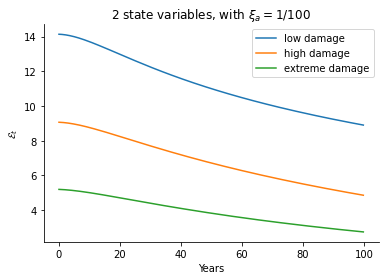

In [91]:
years = np.arange(0, 100, 1/4)
for et, dmg in zip(et_list, ["low", "high", "extreme"]):
    plt.plot(years, et, label=dmg+" damage")
plt.legend()
plt.title("2 state variables, with $\\xi_a = 1/100$")
plt.xlabel("Years")
plt.ylabel("$\mathcal{E}_t$")
# plt.savefig("2state_ems.png", dpi=128, facecolor="w", edgecolor="w", bbox_inches="tight")

In [ ]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

In [ ]:
plt.plot(years, scc)

In [ ]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1000
ξw = 1000
ξp = 1/20
γ3 = 0
σy = 1e-3
args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw)
ϕ_1d, ems_1d, π_1d,  h_1d = solve_smooth(y1_grid, args,  max_iter=5_000, tol=1e-7, ϵ=1)

In [ ]:
plt.plot(ems_1d)

In [ ]:
def simualte_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [ ]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

In [ ]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

In [ ]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()